<a href="https://colab.research.google.com/github/Amplil/nlp-test/blob/master/random_struct_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期化

In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/packages")

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
#import icecream as ic
import time
import slacknotice # オリジナルモジュール slacknotice.send("")
import traceback
import random

## GNPの関数とGNP実行オブジェクト(printxによる表示のON,OFFあり)

In [ ]:
# 入力ノード数エラー：-1
# 出力およびその他のエラー：-2

class printx(): # ONのときだけ表示
    out_on=False
    @classmethod
    def on(cls):
        cls.out_on=True
    @classmethod
    def off(cls):
        cls.out_on=False
    @classmethod
    def out(cls,*args):
        if cls.out_on:
            print(*args)

def div(gn): # gn: DiGraphNode
    if (gn.in_deg==1): # divの入力ノードは1つ
        if (gn.out_deg==1): # 出力ノードが1つの場合
            if not (type(gn.in_ele_list[0])==list): # 入力ノードの要素がリストでない（複数ない）場合
                result=str(gn.in_ele_list[0]).split() # 入力ノードと入力ノードリストの要素ともに1つだけ
                return gn.out_ele(gn.out_node_list[0],result) # resultを代入、出力ノードは1つだけ
            else:
                printx.out("繰り返し処理の入ったネットワークの繰り返しは関数化によって実現すれば良いため、繰り返し処理で用いるリストの分解深度は1のまま増やさない。すなわち、入力ノードの要素がリストである（複数ある）場合エラー")
                return -2
        elif (gn.out_deg==0): # エンドノードの場合
            return gn.in_ele_list[0] # 入力をそのまま出力
        else: # 複数出力ノードの場合
            if not (type(gn.in_ele_list[0])==list): # 入力ノードの要素がリストでない（複数ない）場合
                result=str(gn.in_ele_list[0]).split() # 入力ノードと入力ノードリストの要素ともに1つだけ
                for num,node in enumerate(gn.out_node_list): # pos要素を追加
                    gn.G.nodes[node]['pos']=num
                return list(map(gn.out_ele,gn.out_node_list,result)) # resultはリスト、resultを代入、出力ノードは1つだけ
            else:
                printx.out("入力ノードの要素がリストである（複数ある）場合、for文と再帰を使い、出力ノードリストの要素が1つになるまで繰り返す。)")
                return -2
    else:
        printx.out("div len args error")
        return -1

def sum(gn): # gn: DiGraphNode
    flatten = lambda x: [z for y in x for z in (flatten(y) if hasattr(y, '__iter__') and not isinstance(y, str) else (y,))]
    word_list=list(map(str,flatten(gn.in_ele_list))) # すべての入力エッジの要素の平坦化された文字列のリスト
    sentense=""
    for word in word_list:
        if (word!="[NULL]"):
            sentense+=word+" "
    result=sentense.rstrip() # 最後のスペースはなくして出力
    if result=="": result="[NULL]" # 結果が何もない場合、"[NULL]"を出力
    printx.out(result)
    for out_node in gn.out_node_list: # 出力ノードは複数でも可
        gn.out_ele(out_node,result)
    return result
def equal(gn):
    if (gn.in_deg==2):
        if (type(gn.in_ele_list[0])!=list and type(gn.in_ele_list[1])!=list):
            ele=[[gn.in_ele_list[i]] for i in range(2)] # 個々にリスト化
        elif (type(gn.in_ele_list[0])==list and type(gn.in_ele_list[1])==list and len(gn.in_ele_list[0])==len(gn.in_ele_list[1])): # 入力がどちらもリストであり、要素数も同じとき
            ele=gn.in_ele_list
        else:
            printx.out("equal nodes list error")
            return -2
        out_list=[]
        for i in range(len(ele[0])): # 繰り返し処理に対応
            if (ele[0][i]==ele[1][i]):
                out="[TRUE]"
            else:
                out="[FALSE]"
            out_list.append(out)
        if (len(out_list)==1):
            result=out_list[0]
        else:
            result=out_list
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        printx.out(result)
        #return gn.out_ele(gn.out_node_list[0],result) # resultを代入、出力ノードは1つだけ
        return result
    else:
        printx.out("equal input nodes len error")
        return -1

def control_gate(gn):
    # 入力のどちらかが[TRUE]である場合はもう片方のリンクの値を通し、それ以外は[NULL]を出力（[FALSE]でなくてもよい）。
    if (gn.in_deg==2): # 入力は2つ、出力はすべての関数で固定しない
        if (type(gn.in_ele_list[0])!=list and type(gn.in_ele_list[1])!=list):
            ele=[[gn.in_ele_list[i]] for i in range(2)] # 個々にリスト化
        elif (type(gn.in_ele_list[0])==list and type(gn.in_ele_list[1])==list and len(gn.in_ele_list[0])==len(gn.in_ele_list[1])): # 入力がどちらもリストであり、要素数も同じとき
            ele=gn.in_ele_list
        else:
            printx.out("control_gate nodes list error")
            return -2
        out_list=[]
        for i in range(len(ele[0])): # 繰り返し処理に対応
            if (ele[0][i]=="[TRUE]"):
                out=ele[1][i]
            elif (ele[1][i]=="[TRUE]"):
                out=ele[0][i]
            else:
                out="[NULL]"
            out_list.append(out)
        if (len(out_list)==1):
            result=out_list[0]
        else:
            result=out_list
        printx.out(result)
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        return result
    else:
        printx.out("control_gate nodes len error")
        return -1
def control_not_gate(gn):
    # 入力のどちらかが[FALSE]である場合はもう片方のリンクの値を通し、それ以外は[NULL]を出力（[TRUE]でなくてもよい）。
    if (gn.in_deg==2): # 入力は2つ、出力はすべての関数で固定しない
        if (type(gn.in_ele_list[0])!=list and type(gn.in_ele_list[1])!=list):
            ele=[[gn.in_ele_list[i]] for i in range(2)] # 個々にリスト化
        elif (type(gn.in_ele_list[0])==list and type(gn.in_ele_list[1])==list and len(gn.in_ele_list[0])==len(gn.in_ele_list[1])): # 入力がどちらもリストであり、要素数も同じとき
            ele=gn.in_ele_list
        else:
            printx.out("control_not_gate nodes list error")
            return -2
        out_list=[]
        for i in range(len(ele[0])): # 繰り返し処理に対応
            if (ele[0][i]=="[FALSE]"):
                out=ele[1][i]
            elif (ele[1][i]=="[FALSE]"):
                out=ele[0][i]
            else:
                out="[NULL]"
            out_list.append(out)
        if (len(out_list)==1):
            result=out_list[0]
        else:
            result=out_list
        printx.out(result)
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        return result
    else:
        printx.out("control_not_gate nodes len error")
        return -1

def pos(gn): # 繰り返し処理により入力ノードの要素がリストになっていても関係ない
    if (gn.in_deg==1):
        pre_gn=DiGraphNode(gn.G,gn.in_node_list[0])
        if (pre_gn.in_deg==0):
            printx.out("pos input node input is start node")
            #result=-2
            result=0 # 入力の入力がない場合は0と出力することにする
        elif (pre_gn.in_deg==1):
            result=pre_gn.G.nodes[pre_gn.in_node_list[0]].get('pos')
            if result==None:
                printx.out("node pos does not exist")
                #result=""
                printx.out("node pos does not exist. result=0")
                result=0 # pos要素がない場合は0と出力することにする
        else:
            printx.out("pos input node input is plural")
            result=-2
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        return result
    else:
        printx.out("pos input node len error")
        return -1
def out_func(gn): # 出力は繰り返し処理なし
    if (gn.in_deg==1 and gn.out_deg==0):
        result=gn.in_ele_list[0]
        #self.output=result
        return result
    else:
        printx.out("out_func nodes len error")
        return -1
#def node_func(gn): # 繰り返し処理により入力ノードの要素がリストになっている場合、リストのまま出力する
def object_func(gn): # 繰り返し処理により入力ノードの要素がリストになっている場合、リストのまま出力する
    if (gn.in_deg==1):
        """
        if (gn.out_deg==0): # object_funcにエンドポイント機能を持たせる
            #result="(end point) "+str(gn.in_ele_list[0])
            result=str(gn.in_ele_list[0])
        else:
        """
        result=gn.in_ele_list[0]
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        return result
    else:
        printx.out("object_func input nodes len error")
        return -1


class DiGraphNode(): # 有向グラフの1つのノードにフォーカス
    def __init__(self,G,node):
        self.G=G
        self.node=node
        if (node in G.nodes)==False:
            printx.out('Error: ',node,' does not exist in the graph')
            self.ele=''
            self.in_deg=0
            self.out_deg=0
            self.in_node_list=[]
            self.out_node_list=[]
            self.in_ele_list=[] # in edge element list
            self.out_ele_list=[] # out edge element list
        else:
            self.ele=G.nodes[node]['ele']
            self.in_deg=G.in_degree(node)
            self.out_deg=G.out_degree(node)
            self.in_node_list=list(G.pred[node])
            self.out_node_list=list(G[node])
            self.in_ele_list=[G.edges[n,node]['ele'] for n in self.in_node_list] # in edge element list
            self.out_ele_list=[G.edges[node,n]['ele'] for n in self.out_node_list] # out edge element list
        
    def in_ele(self,in_node,element=None): # in edge element
        if(element!=None):
            self.G.edges[in_node,self.node]['ele']=element
        return self.G.edges[in_node,self.node]['ele']
    def out_ele(self,out_node,element=None): # out edge element
        if(element!=None):
            self.G.edges[self.node,out_node]['ele']=element
        return self.G.edges[self.node,out_node]['ele']
    def run_check(self):
        if not callable(self.ele): # ノード要素が関数でない場合(変数(オブジェクト:文字列)のとき)
            printx.out("This is probably object string node.")
            return -3
        else:
            result=self.ele(self)
            """
            if result==-1:
                #print("input error")
            elif result==-2:
                #print("output error")
            else:
                #print(result)
            """
            return result


class GraphStructuredProgram():
    #def __init__(self,input,node_struct,edge_struct):
    def __init__(self,input,node_body,edge_struct):
        #self.input="0 1 0"
        self.input=input
        self.output=""
        self.network=nx.DiGraph()

        node_struct=[('in',input)]
        node_struct.extend(node_body)
        #node_struct.append(('out',out_func))
        self.network.add_nodes_from([(tup[0],{'ele':tup[1]}) for tup in node_struct]) # node_structをnetworkxに対応した形にして渡す
        self.network.add_edges_from(edge_struct)
        self.network.add_edges_from(list(map(lambda tup: tup+({'ele': ''},) ,self.network.edges))) # エッジ要素を''で初期化する
        for node in self.network.nodes:
            gn=DiGraphNode(self.network,node)
            if not callable(gn.ele): # ノード要素が関数でない場合(変数(オブジェクト:文字列)のとき)
                [gn.out_ele(out_node,gn.ele) for out_node in gn.out_node_list] # 出力エッジ要素をノード要素とする

    def network_show(self):
        print("nodes: ",self.network.nodes.data())
        print("edges: ",self.network.edges.data())
        nx.draw_networkx(self.network)
        plt.show()        

    def run_tick(self,node_list):
        next_node_list=[]
        for node in node_list:
            gn=DiGraphNode(self.network,node) # graph node
            if not callable(gn.ele): # ノード要素が関数でない場合(変数(オブジェクト:文字列)のとき)
                printx.out("Error: This is probably object string node.")
                return []
            elif (gn.out_deg!=0 and gn.out_ele_list[0]!=""): # 出力エッジの最初の要素の中身で既に実行されているかどうかを判断する
                result="already calculated: skip"
            elif ("" in gn.in_ele_list): # 入力エッジの要素に""があるかどうかで、まだ入力が実行されていないノードがあるかどうかを判断する
                result="inputs are not calculated yet: skip"
            else:
                result=gn.ele(gn)
                if gn.out_deg==0:
                    printx.out("This is end node")
                    #result=gn.ele(gn)
                    self.output=result
                if type(result)==int and result<0: return result # マイナスの数値の場合エラーのためネクストノードを追加しない
                next_node_list.extend(gn.out_node_list)

            printx.out("node:",node,", result:",result)

        printx.out("next_node_list:",next_node_list)
        return next_node_list

    def run(self):
        #self.network_show()
        if not 'in' in list(self.network.nodes):
            printx.out("'in' node doesn't exist")
            return ''
        printx.out("node: in =",self.network.nodes['in']['ele'])
        next_node_list=list(self.network["in"])
        printx.out("next_node_list:",next_node_list)
        while next_node_list!=[]:
            next_node_list=self.run_tick(next_node_list)
            if type(next_node_list)==int: return next_node_list
        return self.output

## 自動定義関数

In [ ]:
def adfs(gn,node_body,edge_struct): # 自動定義関数
    #if (gn.in_deg==1 and gn.out_deg==1): # 入力も出力もノードは1つ
    printx.out("adfs node_body: ",node_body)
    printx.out("adfs edge_struct: ",edge_struct)
    if (gn.in_deg==1): # 入力は1つ
        if (type(gn.in_ele_list[0])!=list): # 繰り返し処理に対応
            in_list=[gn.in_ele_list[0]]
        else:
            in_list=gn.in_ele_list[0]

        out_list=[]
        #printx.out("adfs input:",in_list)
        for input in in_list: # 繰り返し処理に対応
            printx.out("adfs input:",input)
            #node_struct=[('in',input)]
            #node_struct.extend(node_body)
            #node_struct.append(('out',out_func))
            #gsp=GraphStructuredProgram(input,node_struct,edge_struct)
            gsp=GraphStructuredProgram(input,node_body,edge_struct)
            out=gsp.run()
            out_list.append(out)
        if (len(out_list)==1):
            result=out_list[0]
        else:
            result=out_list
        #return gn.out_ele(gn.out_node_list[0],result) # resultを代入、出力ノードは1つだけ

        printx.out(result)
        for out_node in gn.out_node_list: # 出力ノードは複数でも可
            gn.out_ele(out_node,result)
        return result
    else: return -1

## ネットワーク構築オブジェクト

In [ ]:
class GNPStruct(): # ネットワーク構築オブジェクト
    def __init__(self,num_nodes):
        self.num_nodes=num_nodes
        self.repeat_num=0 # 繰り返し回数
        self.clear1=0
        #self.node_body=[]
        #self.edge_struct=[]
        self.adfs_list=[div,sum,equal,control_gate,control_not_gate,pos,object_func] # まずは初期関数リストでadfsリストを定義 出力関数は入れない

    def add_adfs(self,*add_tupple): # *add_tuppleは可変長引数
        for node in add_tupple:
            if not (node in self.adfs_list): # すでにadfsに登録されているものは追加しない
                self.adfs_list.append(node) # （入出力）オブジェクト(文字列)をadfsリストに登録

    def random_struct(self): # node_num: ノードを何個とるか inを含めない
        #node_num=3 # ノードを何個とるか inを含めない
        #node_list=[input]
        node_list=[] # inを含めない
        #node_list.extend([random.choice(adfs_list) for n in range(node_num)]) # ランダムに選んで加える
        node_list.extend(random.choices(self.adfs_list,k=self.num_nodes)) # ランダムに選んで加える
        node_struct=[('in','dummy')] # あとでinputは抜かす
        node_struct.extend(list(enumerate(node_list))) # inも含めたランダムに作られたノード構造
        node_name_list=[i for i,_ in node_struct] # node_nameだけのリスト
        #self.node_name_list=node_name_list
        if not (True in map(callable,[i for _,i in node_struct])): # node_structに呼び出し可能なノード(関数)が1つもない場合
            print("random_struct: すべてオブジェクトノードのnode_structであったため、スキップします。")
            node_body=[]
            edge_struct=[]
            return # すべてオブジェクトノードであった場合、inをedge_structに入れることができなくなってしまう。

        #connect_list=[]
        edge_struct=[]
        n=0
        while not 'in' in [i for i,_ in edge_struct]: # inを含むedge_structができるまでランダムに作り続ける
            n+=1
            if(n>1000):
                print("random_struct: ",n,"回edgeの構築を繰り返しましたが、inを含むedge_structができませんでした。node_struct: ",node_struct)
                node_body=[]
                edge_struct=[]
                return
            edge_struct=[]
            #for i,node in enumerate(node_list):
            for node_name,node_content in node_struct:
                if callable(node_content):
                    node_sample=list(filter(lambda x: x!=node_name,node_name_list)) # 当ノードを除いたサンプルを用意する
                    #node_sample.remove(node_name) # 当ノードを除いたサンプルを用意する

                    #print(node_content)
                    #print(node_sample)
                    #print(node_name_list)
                    ncn=node_content.__name__
                    if ncn=="equal" or ncn=="control_gate" or ncn=="control_not_gate":
                        #connect_list.extend([i,i]) # 2つ取る
                        edge_struct.extend([(in_node,node_name) for in_node in random.sample(node_sample,2)]) # 入力ノードを重複なしでランダムに2つ選ぶ
                    elif ncn=="sum":
                        repeat=random.randrange(1,self.num_nodes) # sumの入力の本数は1～node_num（取れる最大のノード数）のうちでランダムに決める
                        edge_struct.extend([(in_node,node_name) for in_node in random.sample(node_sample,repeat)]) # 入力ノードを重複なしでランダムにrepeat分選ぶ
                        #connect_list.extend([i for _ in range(repeat)]) # repeat分取る
                    else:
                        edge_struct.append((random.choice(node_sample),node_name)) # 入力ノードをランダムに1つ選ぶ
                        #connect_list.append(i) # 1つ取る
                        #print('else')
            """
            if not 'in' in [i for i,_ in edge_struct] :
                print(node_struct)
                print(edge_struct)
                print('no in')
            """
        """
        edge_struct=[]
        for connect_num in connect_list:
            node_num_range=list(range(node_num+1)) # inも含める
            node_num_range.pop(connect_num) # 当connectは含めない
            edge_struct.append((random.choice(node_num_range),connect_num))
        """
        node_body=node_struct[1:] # inputを抜かす
        return node_body,edge_struct # node_body,edge_structを渡す

    def Search2RequirementsWithAnalysis(self,input1,out_expect1,input2,out_expect2,timelimit=0,interval=0): # 2条件での解析を伴う探索
        self.input1=input1
        self.out_expect1=out_expect1
        self.input2=input2
        self.out_expect2=out_expect2
        self.start_time=time.time()
        self.half_time=time.time()
        self.timelimit=timelimit
        self.interval=interval
        self.result1=""
        self.result2=""
        #self.adfs_list.extend([self.input1,self.out_expect1,self.input2,self.out_expect2]) # （入出力）オブジェクト(文字列)をadfsリストに登録
        #add_list=[self.input1,self.out_expect1,self.input2,self.out_expect2]
        """
        for node in add_list:
            if not (node in self.adfs_list): # すでにadfsに登録されているものは追加しない
                self.adfs_list.append(node) # （入出力）オブジェクト(文字列)をadfsリストに登録
        """
        self.add_adfs(self.input1,self.out_expect1,self.input2,self.out_expect2)
        n=0 # インターバル内の繰り返し回数
        while self.result1!=self.out_expect1 or self.result2!=self.out_expect2:
            self.repeat_num+=1
            n+=1
            if n>1000:
                n=0
                self.now_time=time.time()
                elapsed_time=self.now_time-self.start_time
                if self.timelimit>0 and elapsed_time>=self.timelimit:
                    #print(elapsed_time,"秒経過しましたが、条件を満たすネットワークを見つけることができませんでした。")
                    slacknotice.send(elapsed_time,"秒経過しましたが、条件を満たすネットワークを見つけることができませんでした。")
                    return -1

                if self.interval>0 and self.now_time-self.half_time>=self.interval:
                    #print(elapsed_time,"秒経過 ","生成されたグラフの数: ",self.repeat_num,",第一条件をクリアしたグラフの数: ",self.clear1)
                    slacknotice.send(elapsed_time,"秒経過 ","生成されたグラフの数: ",self.repeat_num,",第一条件をクリアしたグラフの数: ",self.clear1)
                    self.half_time=self.now_time
                    self.clear1=0
                    self.repeat_num=0
            node_body,edge_struct=self.random_struct()
            #print(node_body)
            #print(edge_struct)
            self.gsp1=GraphStructuredProgram(self.input1,node_body,edge_struct)
            self.result1=self.gsp1.run()
            if self.result1!=self.out_expect1:
                continue
            #print("result1 is ok")
            self.clear1+=1
            self.gsp2=GraphStructuredProgram(self.input2,node_body,edge_struct)
            self.result2=self.gsp2.run()
        self.add_adfs(lambda gn : adfs(gn,node_body,edge_struct)) # 条件を満たすネットワークをadfsリストに登録
        self.gsp1.network_show()
        #self.gsp2.network_show()

    def Search1Requirement(self,input,out_expect): # 1条件での探索
        self.result=""
        self.add_adfs(input)
        while self.result!=out_expect:
            node_body,edge_struct=self.random_struct()
            self.gsp=GraphStructuredProgram(input,node_body,edge_struct)
            self.result=self.gsp.run()
        self.add_adfs(lambda gn : adfs(gn,node_body,edge_struct)) # 条件を満たすネットワークをadfsリストに登録
        self.gsp.network_show()

    def PhasedGenerate(self,input1,out_expect1,input2,out_expect2,timelimit=0,interval=0):
        #add_list=[input1,out_expect1,input2,out_expect2]
        self.add_adfs(input1,out_expect1,input2,out_expect2)
        self.Search1Requirement(input1,out_expect1)
        self.Search1Requirement(input2,out_expect2)
        self.Search2RequirementsWithAnalysis(input1,out_expect1,input2,out_expect2,timelimit=timelimit,interval=interval)

# 結果の解析

In [ ]:
# 時間無制限で実行、slackでお知らせ（colabを閉じていても大丈夫）
num_nodes=15
gnps=GNPStruct(num_nodes)
try:
    gnps.Search2RequirementsWithAnalysis("0","1","1","0",interval=1800) # input1,out_expect1,input2,out_expect2,timelimit
except:
    traceback.print_exc()
    slacknotice.send("2条件満たすネットワークの探索においてエラーが発生しました。エラー内容: "+traceback.format_exc())
else:
    slacknotice.send("終了しました。node_body: "+str(gnps.node_body)+" ,edge_struct: "+str(gnps.edge_struct))

slack message: 2条件満たすネットワークの探索においてエラーが発生しました。エラー内容: Traceback (most recent call last):
  File "<ipython-input-7-45b21b181004>", line 5, in <module>
    gnps.Search2RequirementsWithAnalysis("0","1","1","0",interval=1800) # input1,out_expect1,input2,out_expect2,timelimit
  File "<ipython-input-6-a47409d6ec4f>", line 117, in Search2RequirementsWithAnalysis
    self.random_struct()
  File "<ipython-input-6-a47409d6ec4f>", line 54, in random_struct
    self.edge_struct.extend([(in_node,node_name) for in_node in random.sample(node_sample,2)]) # 入力ノードを重複なしでランダムに2つ選ぶ
  File "/usr/lib/python3.7/random.py", line 314, in sample
    if isinstance(population, _Set):
  File "/usr/lib/python3.7/abc.py", line 139, in __instancecheck__
    return _abc_instancecheck(cls, instance)
KeyboardInterrupt



Traceback (most recent call last):
  File "<ipython-input-7-45b21b181004>", line 5, in <module>
    gnps.Search2RequirementsWithAnalysis("0","1","1","0",interval=1800) # input1,out_expect1,input2,out_expect2,timelimit
  File "<ipython-input-6-a47409d6ec4f>", line 117, in Search2RequirementsWithAnalysis
    self.random_struct()
  File "<ipython-input-6-a47409d6ec4f>", line 54, in random_struct
    self.edge_struct.extend([(in_node,node_name) for in_node in random.sample(node_sample,2)]) # 入力ノードを重複なしでランダムに2つ選ぶ
  File "/usr/lib/python3.7/random.py", line 314, in sample
    if isinstance(population, _Set):
  File "/usr/lib/python3.7/abc.py", line 139, in __instancecheck__
    return _abc_instancecheck(cls, instance)
KeyboardInterrupt


[('in', {'ele': '0'}), (0, {'ele': <function sum at 0x7f376ad45200>, 'pos': 0}), (1, {'ele': '1'}), (2, {'ele': '1'}), (3, {'ele': '0'}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function div at 0x7f376ad45560>}), (6, {'ele': <function equal at 0x7f376ad45b90>}), (7, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (8, {'ele': <function sum at 0x7f376ad45200>}), (9, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 1}), (10, {'ele': <function sum at 0x7f376ad45200>, 'pos': 2}), (11, {'ele': '1'}), (12, {'ele': <function div at 0x7f376ad45560>}), (13, {'ele': <function object_func at 0x7f37622a3680>}), (14, {'ele': <function control_not_gate at 0x7f376ad45e60>})]
[('in', 5, {'ele': '0'}), ('in', 6, {'ele': '0'}), (0, 8, {'ele': ''}), (0, 14, {'ele': ''}), (1, 0, {'ele': '1'}), (1, 6, {'ele': '1'}), (1, 7, {'ele': '1'}), (1, 8, {'ele': '1'}), (1, 14, {'ele': '1'}), (2, 8, {'ele': '1'}), (3, 0, {'ele': '0'}), (4, 0, {'ele': ''}), (5, 0, {'ele': '0'}), 

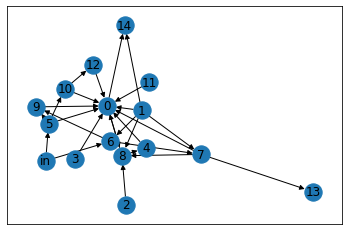

[('in', {'ele': '1'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function pos at 0x7f37622a3290>}), (2, {'ele': <function sum at 0x7f376ad45200>}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function control_gate at 0x7f376ad45cb0>}), (5, {'ele': '1'}), (6, {'ele': '0'}), (7, {'ele': '0'}), (8, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (9, {'ele': '0'}), (10, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>}), (11, {'ele': '0'}), (12, {'ele': <function equal at 0x7f376ad45b90>}), (13, {'ele': '1'}), (14, {'ele': <function equal at 0x7f376ad45b90>})]
[('in', 3, {'ele': '1'}), ('in', 4, {'ele': '1'}), (0, 10, {'ele': '[FALSE]'}), (3, 2, {'ele': 0}), (3, 14, {'ele': 0}), (4, 2, {'ele': '[NULL]'}), (4, 14, {'ele': '[NULL]'}), (6, 12, {'ele': '0'}), (8, 2, {'ele': '[NULL]'}), (9, 0, {'ele': '0'}), (9, 1, {'ele': '0'}), (9, 12, {'ele': '0'}), (10, 8, {'ele': '1'}), (13, 4, {'ele': '1'}), (13, 8, {'ele': 

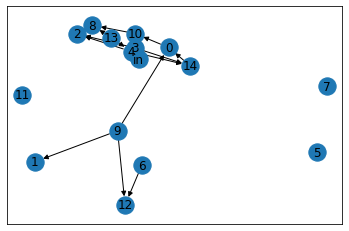

[('in', {'ele': '0'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (2, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 0}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function control_gate at 0x7f376ad45cb0>}), (6, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (7, {'ele': '1'}), (8, {'ele': <function control_gate at 0x7f376ad45cb0>}), (9, {'ele': <function equal at 0x7f376ad45b90>}), (10, {'ele': '0'}), (11, {'ele': <function div at 0x7f376ad45560>}), (12, {'ele': '0'}), (13, {'ele': <function div at 0x7f376ad45560>}), (14, {'ele': <function div at 0x7f376ad45560>, 'pos': 1})]
[('in', 0, {'ele': '0'}), (0, 1, {'ele': '[TRUE]'}), (0, 6, {'ele': '[TRUE]'}), (1, 4, {'ele': '0 1'}), (1, 11, {'ele': '0 1'}), (1, 13, {'ele': '0 1'}), (2, 9, {'ele': ''}), (3, 8, {'ele': ''}), (7, 3

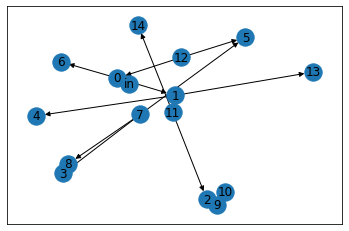

In [ ]:
num_nodes=15
gnps=GNPStruct(num_nodes)
gnps.PhasedGenerate("0","1","1","0",interval=1800)

In [ ]:
add_list=[self.input1,self.out_expect1,self.input2,self.out_expect2]
add_adfs(add_list)
Search1Requirement(self.input1,self.out_expect1)
Search1Requirement(self.input2,self.out_expect2)
Search2RequirementsWithAnalysis(input1,out_expect1,input2,out_expect2,timelimit=timelimit,interval=interval)

NameError: ignored

In [ ]:
[(0,sum), (1, {'ele': '1'}), (2, {'ele': '1'}), (3, {'ele': '0'}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function div at 0x7f376ad45560>}), (6, {'ele': <function equal at 0x7f376ad45b90>}), (7, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (8, {'ele': <function sum at 0x7f376ad45200>}), (9, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 1}), (10, {'ele': <function sum at 0x7f376ad45200>, 'pos': 2}), (11, {'ele': '1'}), (12, {'ele': <function div at 0x7f376ad45560>}), (13, {'ele': <function object_func at 0x7f37622a3680>}), (14, {'ele': <function control_not_gate at 0x7f376ad45e60>})]
[('in', 5, {'ele': '0'}), ('in', 6, {'ele': '0'}), (0, 8, {'ele': ''}), (0, 14, {'ele': ''}), (1, 0, {'ele': '1'}), (1, 6, {'ele': '1'}), (1, 7, {'ele': '1'}), (1, 8, {'ele': '1'}), (1, 14, {'ele': '1'}), (2, 8, {'ele': '1'}), (3, 0, {'ele': '0'}), (4, 0, {'ele': ''}), (5, 0, {'ele': '0'}), (5, 9, {'ele': ''}), (5, 10, {'ele': ''}), (6, 7, {'ele': '[FALSE]'}), (6, 9, {'ele': '[FALSE]'}), (7, 0, {'ele': '1'}), (7, 8, {'ele': '1'}), (7, 13, {'ele': '1'}), (8, 0, {'ele': ''}), (8, 4, {'ele': ''}), (9, 0, {'ele': ''}), (10, 0, {'ele': ''}), (10, 12, {'ele': ''}), (11, 0, {'ele': '1'}), (12, 0, {'ele': ''})]

# テスト

In [ ]:
num_nodes=10
gnps=GNPStruct(num_nodes)
gnps.Search2RequirementsWithAnalysis("0","1","1","0",timelimit=300,interval=60) # input1,out_expect1,input2,out_expect2

In [ ]:
gnps.node_body

[(0, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
 (1, <function __main__.pos>),
 (2, <function __main__.equal>),
 (3, '0'),
 (4, <function __main__.object_func>),
 (5, <function __main__.control_gate>),
 (6, <function __main__.div>),
 (7, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
 (8, '1'),
 (9, <function __main__.sum>),
 (10, <function __main__.object_func>),
 (11, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
 (12, <function __main__.div>),
 (13, <function __main__.div>),
 (14, '1')]

In [ ]:
printx.on()

In [ ]:
gsptest=GraphStructuredProgram("0",gnps.node_body,gnps.edge_struct)
gsptest.run()

In [ ]:
node_body1=[(0,sum), (1,equal), (2, control_gate), (3,sum), (4, '1'), 
            (5,sum), (6,control_not_gate), (7, '0'), (8, '0'), (9,control_not_gate), 
            (10,object_func), (11, '1'), (12, sum), (13, pos), (14, control_not_gate)]
edge_struct1=[(13, 0), (10, 0), (8, 0), (4, 0), (4, 1), 
              ('in', 1), (10, 2), (7, 2), (8, 3), (9, 3), 
              (0, 3), (2, 3), (10, 3), (8, 5), (7, 5), 
              (11, 5), ('in', 5), (11, 6), (2, 6), (10, 9), 
              (11, 9), (1, 10), (9, 12), (2, 12), (0, 12), 
              (7, 13), (11, 14), (2, 14)]
gsptest=GraphStructuredProgram("0",node_body1,edge_struct1)
gsptest.run()

In [ ]:
printx.off()

In [ ]:
gsptest=GraphStructuredProgram("0",node_body1,edge_struct1)
gsptest.run()

In [ ]:
node_body2=[(0, '1'), (1, object_func), (2, equal), (3, '0'), (4, control_not_gate),
            (5, control_not_gate), (6, control_gate), (7, '0'), (8, '1'), (9, equal), 
            (10, '1'), (11,sum), (12, sum), (13, '1'), (14, pos)]
edge_struct2=[(5, 1), (4, 2), (9, 2), (9, 4), (13, 4),
             (3, 5), ('in', 5), (9, 6), (7, 6), ('in', 9), 
             (13, 9), (1, 11), (14, 11), (4, 11), (4, 12), 
             (5, 12), (6, 12), (11, 14)]

In [ ]:
gsptest=GraphStructuredProgram("1",node_body2,edge_struct2)
gsptest.run()

In [ ]:
[0,"2","","3","",5].count("")

In [ ]:
"" in [0,"2","","3","",5]

In [ ]:
[0,"2","3",5].count("")

In [ ]:
"" in [0,"2","3",5]

In [ ]:
gnps.node_body.append((10,"0"))

In [ ]:
list(map(type,[i for _,i in gnps.node_body]))

In [ ]:
list(map(callable,[i for _,i in gnps.node_body]))

In [ ]:
list(map(callable,[i for _,i in [('in', 'dummy'), (0, '0'), (1, '1'), (2, '0'), (3, '1'), (4, '1'), (5, '1'), (6, '1'), (7, '0'), (8, '0'), (9, '0'), (10, '1'), (11, '0'), (12, '0'), (13, '1'), (14, '0')]]))

In [ ]:
False in map(callable,[i for _,i in gnps.node_body])

In [ ]:
False in map(callable,[i for _,i in [('in', 'dummy'), (0, '0'), (1, '1'), (2, '0'), (3, '1'), (4, '1'), (5, '1'), (6, '1'), (7, '0'), (8, '0'), (9, '0'), (10, '1'), (11, '0'), (12, '0'), (13, '1'), (14, '0')]])

In [ ]:
True in map(callable,[i for _,i in gnps.node_body])

In [ ]:
True in map(callable,[i for _,i in [('in', 'dummy'), (0, '0'), (1, '1'), (2, '0'), (3, '1'), (4, '1'), (5, '1'), (6, '1'), (7, '0'), (8, '0'), (9, '0'), (10, '1'), (11, '0'), (12, '0'), (13, '1'), (14, '0')]])

In [ ]:
gsptest=GraphStructuredProgram("0",[],[])

In [ ]:
gsptest.run()

In [ ]:
gnps.node_name_list

In [ ]:
gnps.adfs_list

In [ ]:
add_list=[gnps.input1,gnps.out_expect1,gnps.input2,gnps.out_expect2]
add_list

In [ ]:
add_list[0] in gnps.adfs_list

In [ ]:
add_list.append('2')
add_list

In [ ]:
for node in add_list:
    if not (node in gnps.adfs_list): # すでにadfsに登録されているものは追加しない
        gnps.adfs_list.append(node)

In [ ]:
gnps.adfs_list

In [ ]:
gnps.node_body,gnps.edge_struct

([(0, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
  (1, <function __main__.pos>),
  (2, <function __main__.equal>),
  (3, '0'),
  (4, <function __main__.object_func>),
  (5, <function __main__.control_gate>),
  (6, <function __main__.div>),
  (7, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
  (8, '1'),
  (9, <function __main__.sum>),
  (10, <function __main__.object_func>),
  (11, <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>),
  (12, <function __main__.div>),
  (13, <function __main__.div>),
  (14, '1')],
 [('in', 0),
  (7, 1),
  (6, 2),
  (9, 2),
  (13, 4),
  (9, 5),
  (8, 5),
  (3, 6),
  (4, 7),
  (4, 9),
  ('in', 9),
  (7, 9),
  (3, 9),
  (10, 9),
  (6, 9),
  (14, 9),
  (8, 9),
  (13, 9),
  (12, 9),
  (0, 9),
  (5, 9),
  (11, 9),
  (9, 10),
  (4, 11),
  (1, 12),
  (3, 13)])

In [ ]:
gnps.clear1

In [ ]:
gnps.now_time-gnps.start_time

In [ ]:
gnps.edge_struct

In [ ]:
[i for i,_ in gnps.edge_struct]

In [ ]:
node_name_list=[i[0] for i in node_struct] # node_nameだけのリスト
node_name_list

In [ ]:
gnps.random_struct()
gnps.node_body,gnps.edge_struct

In [ ]:
# 2条件プログラムの確認
gnps.node_body=[(1,'0'),(2,'1'),(3,equal),(4,equal),(5,'1'),(6,'0'),(7,control_gate),(8,control_gate),(9,sum)]
gnps.edge_struct=[('in',3),('in',4),(1,3),(2,4),(3,7),(4,8),(5,7),(6,8),(7,9),(8,9)]
n=0
while gnps.result1!=gnps.out_expect1 or result2!=gnps.out_expect2:
    n+=1
    #node_struct,edge_struct=random_struct(20) # 最初から与えておく
    #print(node_struct)
    #print(edge_struct)
    gnps.gsp1=GraphStructuredProgram(gnps.input1,gnps.node_body,gnps.edge_struct)
    gnps.result1=gnps.gsp1.run()
    if gnps.result1!=gnps.out_expect1:
        continue
    #print("result1 is ok")
    gnps.gsp2=GraphStructuredProgram(gnps.input2,gnps.node_body,gnps.edge_struct)
    result2=gnps.gsp2.run()

gnps.gsp1.network_show()
gnps.gsp2.network_show()
gnps.node_body,gnps.edge_struct

In [ ]:
slacknotice.send("テスト")

In [ ]:
printx("a")

In [ ]:
class printx(): # ONのときだけ表示
    message=""
    out_on=False
    @classmethod
    def on(cls):
        cls.out_on=True
    @classmethod
    def off(cls):
        cls.out_on=False
    @classmethod
    def out(cls,*args):
        if cls.out_on:
            print(*args)

In [ ]:
printx.add("a")

In [ ]:
printx.add("b","c")

In [ ]:
printx.out()

In [ ]:
printx.out_on="abc"

In [ ]:
printx.out_on

In [ ]:
printx.on()

In [ ]:
printx.out("abc")

In [ ]:
printx.off()

## adfsテスト

In [ ]:
gnps_adfs=lambda gn : adfs(gn,gnps.node_body,gnps.edge_struct)
gnps_adfs

<function __main__.<lambda>>

In [ ]:
gnps.node_body,gnps.edge_struct

AttributeError: ignored

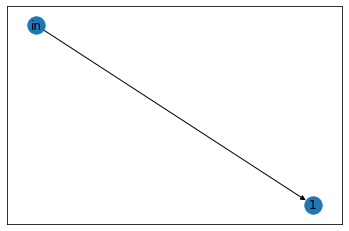

node: in = 0
next_node_list: [1]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
node: in = 0
next_node_list: [0, 9]
adfs input: 0
nod

RecursionError: ignored

In [ ]:
node_body=[(1,gnps_adfs)]
edge_struct=[('in',1)]
gsp=GraphStructuredProgram("0",node_body,edge_struct)
gsp.network_show()
gsp.run()

In [ ]:
gnps.adfs_list

[<function __main__.div>,
 <function __main__.sum>,
 <function __main__.equal>,
 <function __main__.control_gate>,
 <function __main__.control_not_gate>,
 <function __main__.pos>,
 <function __main__.object_func>,
 '0',
 '1',
 <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>,
 <function __main__.GNPStruct.Search1Requirement.<locals>.<lambda>>,
 <function __main__.GNPStruct.Search2RequirementsWithAnalysis.<locals>.<lambda>>]

In [ ]:
node_body_not=[(1,'0'),(2,'1'),(3,equal),(4,equal),(5,'1'),(6,'0'),(7,control_gate),(8,control_gate),(9,sum)]
edge_struct_not=[('in',3),('in',4),(1,3),(2,4),(3,7),(4,8),(5,7),(6,8),(7,9),(8,9)]
gnps.add_adfs(lambda gn : adfs(gn,node_body_not,edge_struct_not))

In [ ]:
gnps.adfs_list[11]

<function __main__.GNPStruct.Search2RequirementsWithAnalysis.<locals>.<lambda>>

In [ ]:
printx.on()

nodes:  [('in', {'ele': '0'}), (1, {'ele': <function GNPStruct.Search2RequirementsWithAnalysis.<locals>.<lambda> at 0x7f37626ec560>})]
edges:  [('in', 1, {'ele': '0'})]


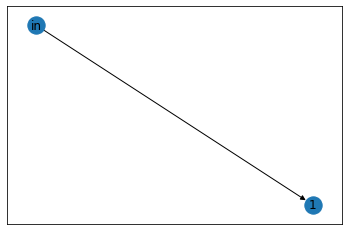

node: in = 0
next_node_list: [1]
adfs node_body: [(0, <function equal at 0x7f376ad45b90>), (1, <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>), (2, <function equal at 0x7f376ad45b90>), (3, <function pos at 0x7f37622a3290>), (4, <function object_func at 0x7f37622a3680>), (5, <function control_gate at 0x7f376ad45cb0>), (6, <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>), (7, '1'), (8, <function control_gate at 0x7f376ad45cb0>), (9, <function equal at 0x7f376ad45b90>), (10, '0'), (11, <function div at 0x7f376ad45560>), (12, '0'), (13, <function div at 0x7f376ad45560>), (14, <function div at 0x7f376ad45560>)]
adfs edge_struct: [(12, 0), ('in', 0), (0, 1), (9, 2), (11, 2), (7, 3), (1, 4), (7, 5), (12, 5), (0, 6), (3, 8), (7, 8), (10, 9), (2, 9), (1, 11), (1, 13), (11, 14)]
adfs input: 0
node: in = 0
next_node_list: [0]
[TRUE]
node: 0 , result: [TRUE]
next_node_list: [1, 6]
adfs node_body: [(0, <function equal at 0x7f376ad45b90>), (1,

'1'

In [ ]:
#node_body=[(1,gnps.adfs_list[10]),('out',out_func)]
#edge_struct=[('in',1),(1,'out')]
node_body=[(1,gnps.adfs_list[11])]
edge_struct=[('in',1)]
gsp=GraphStructuredProgram("0",node_body,edge_struct)
gsp.network_show()
gsp.run()

In [ ]:
printx.off()

# 出力されたネットワーク（ノードとエッジ）の情報から、node_body,edge_structに変換

In [14]:
netinfo_str="[('in', {'ele': '0'}), (0, {'ele': <function sum at 0x7f376ad45200>, 'pos': 0}), (1, {'ele': '1'}), (2, {'ele': '1'}), (3, {'ele': '0'}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function div at 0x7f376ad45560>}), (6, {'ele': <function equal at 0x7f376ad45b90>}), (7, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (8, {'ele': <function sum at 0x7f376ad45200>}), (9, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 1}), (10, {'ele': <function sum at 0x7f376ad45200>, 'pos': 2}), (11, {'ele': '1'}), (12, {'ele': <function div at 0x7f376ad45560>}), (13, {'ele': <function object_func at 0x7f37622a3680>}), (14, {'ele': <function control_not_gate at 0x7f376ad45e60>})]"

In [61]:
netinfo_rep=netinfo_str.replace("<","'<").replace(">",">'")
netinfo_rep

"[('in', {'ele': '0'}), (0, {'ele': '<function sum at 0x7f376ad45200>', 'pos': 0}), (1, {'ele': '1'}), (2, {'ele': '1'}), (3, {'ele': '0'}), (4, {'ele': '<function object_func at 0x7f37622a3680>'}), (5, {'ele': '<function div at 0x7f376ad45560>'}), (6, {'ele': '<function equal at 0x7f376ad45b90>'}), (7, {'ele': '<function control_not_gate at 0x7f376ad45e60>'}), (8, {'ele': '<function sum at 0x7f376ad45200>'}), (9, {'ele': '<function equal at 0x7f376ad45b90>', 'pos': 1}), (10, {'ele': '<function sum at 0x7f376ad45200>', 'pos': 2}), (11, {'ele': '1'}), (12, {'ele': '<function div at 0x7f376ad45560>'}), (13, {'ele': '<function object_func at 0x7f37622a3680>'}), (14, {'ele': '<function control_not_gate at 0x7f376ad45e60>'})]"

In [62]:
node_info=eval(netinfo_rep)
node_info

[('in', {'ele': '0'}),
 (0, {'ele': '<function sum at 0x7f376ad45200>', 'pos': 0}),
 (1, {'ele': '1'}),
 (2, {'ele': '1'}),
 (3, {'ele': '0'}),
 (4, {'ele': '<function object_func at 0x7f37622a3680>'}),
 (5, {'ele': '<function div at 0x7f376ad45560>'}),
 (6, {'ele': '<function equal at 0x7f376ad45b90>'}),
 (7, {'ele': '<function control_not_gate at 0x7f376ad45e60>'}),
 (8, {'ele': '<function sum at 0x7f376ad45200>'}),
 (9, {'ele': '<function equal at 0x7f376ad45b90>', 'pos': 1}),
 (10, {'ele': '<function sum at 0x7f376ad45200>', 'pos': 2}),
 (11, {'ele': '1'}),
 (12, {'ele': '<function div at 0x7f376ad45560>'}),
 (13, {'ele': '<function object_func at 0x7f37622a3680>'}),
 (14, {'ele': '<function control_not_gate at 0x7f376ad45e60>'})]

In [43]:
[(node[0],node[1]['ele']) for node in node_info]

[('in', '0'),
 (0, '<function sum at 0x7f376ad45200>'),
 (1, '1'),
 (2, '1'),
 (3, '0'),
 (4, '<function object_func at 0x7f37622a3680>'),
 (5, '<function div at 0x7f376ad45560>'),
 (6, '<function equal at 0x7f376ad45b90>'),
 (7, '<function control_not_gate at 0x7f376ad45e60>'),
 (8, '<function sum at 0x7f376ad45200>'),
 (9, '<function equal at 0x7f376ad45b90>'),
 (10, '<function sum at 0x7f376ad45200>'),
 (11, '1'),
 (12, '<function div at 0x7f376ad45560>'),
 (13, '<function object_func at 0x7f37622a3680>'),
 (14, '<function control_not_gate at 0x7f376ad45e60>')]

In [19]:
type(netinfo[0])

tuple

In [24]:
netinfo[0][1]['ele']

'0'

In [33]:
netinfo[0][1]['ele'].split()

['0']

In [25]:
netinfo[1][1]['ele']

'<function sum at 0x7f376ad45200>'

In [32]:
type(netinfo[1][1]['ele'])==str

True

In [30]:
type(netinfo[1][1]['pos'])

int

In [37]:
"function" in netinfo[1][1]['ele']

True

In [44]:
(type(netinfo[1][1]['ele'])==str and "function" in netinfo[1][1]['ele'])

True

In [46]:
"function" in netinfo[1][1]['pos']

TypeError: ignored

In [45]:
(type(netinfo[1][1]['pos'])==str and "function" in netinfo[1][1]['pos'])

False

In [49]:
ele=netinfo[1][1]['ele']
ele.split()[1] if (type(ele)==str and "function" in ele) else ele

'sum'

In [50]:
ele=netinfo[0][1]['ele']
ele.split()[1] if (type(ele)==str and "function" in ele) else ele

'0'

In [51]:
[(node[0], node[1]['ele'].split()[1] if (type(node[1]['ele'])==str and "function" in node[1]['ele']) else node[1]['ele'] ) for node in node_info]

[('in', '0'),
 (0, 'sum'),
 (1, '1'),
 (2, '1'),
 (3, '0'),
 (4, 'object_func'),
 (5, 'div'),
 (6, 'equal'),
 (7, 'control_not_gate'),
 (8, 'sum'),
 (9, 'equal'),
 (10, 'sum'),
 (11, '1'),
 (12, 'div'),
 (13, 'object_func'),
 (14, 'control_not_gate')]

In [67]:
node_info_str2="[('in', {'ele': '1'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function pos at 0x7f37622a3290>}), (2, {'ele': <function sum at 0x7f376ad45200>}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function control_gate at 0x7f376ad45cb0>}), (5, {'ele': '1'}), (6, {'ele': '0'}), (7, {'ele': '0'}), (8, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (9, {'ele': '0'}), (10, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>}), (11, {'ele': '0'}), (12, {'ele': <function equal at 0x7f376ad45b90>}), (13, {'ele': '1'}), (14, {'ele': <function equal at 0x7f376ad45b90>})]"
node_info_str2

"[('in', {'ele': '1'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function pos at 0x7f37622a3290>}), (2, {'ele': <function sum at 0x7f376ad45200>}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function control_gate at 0x7f376ad45cb0>}), (5, {'ele': '1'}), (6, {'ele': '0'}), (7, {'ele': '0'}), (8, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (9, {'ele': '0'}), (10, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>}), (11, {'ele': '0'}), (12, {'ele': <function equal at 0x7f376ad45b90>}), (13, {'ele': '1'}), (14, {'ele': <function equal at 0x7f376ad45b90>})]"

In [87]:
def trans_node_info(node_info_str):
    node_info=node_info_str.replace(" <"," '<").replace(">}",">'}").replace(">,",">',")
    return [
    (node[0], 
    node[1]['ele'].split()[1] 
    if (type(node[1]['ele'])==str and "function" in node[1]['ele']) 
    else node[1]['ele'] ) 
    for node in node_info]

In [95]:
def trans_node_info(node_info_str):
    node_info=eval(node_info_str.replace(" <"," '<").replace(">}",">'}").replace(">,",">',"))
    #return [(node[0], node[1]['ele'].split()[1] if (type(node[1]['ele'])==str and "function" in node[1]['ele']) else node[1]['ele'] ) for node in node_info]
    return [(node[0],node[1]['ele']) for node in node_info]

In [96]:
trans_node_info(
    "[('in', {'ele': '0'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (2, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 0}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function control_gate at 0x7f376ad45cb0>}), (6, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (7, {'ele': '1'}), (8, {'ele': <function control_gate at 0x7f376ad45cb0>}), (9, {'ele': <function equal at 0x7f376ad45b90>}), (10, {'ele': '0'}), (11, {'ele': <function div at 0x7f376ad45560>}), (12, {'ele': '0'}), (13, {'ele': <function div at 0x7f376ad45560>}), (14, {'ele': <function div at 0x7f376ad45560>, 'pos': 1})]"
)

[('in', '0'),
 (0, '<function equal at 0x7f376ad45b90>'),
 (1,
  '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'),
 (2, '<function equal at 0x7f376ad45b90>'),
 (3, '<function pos at 0x7f37622a3290>'),
 (4, '<function object_func at 0x7f37622a3680>'),
 (5, '<function control_gate at 0x7f376ad45cb0>'),
 (6,
  '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'),
 (7, '1'),
 (8, '<function control_gate at 0x7f376ad45cb0>'),
 (9, '<function equal at 0x7f376ad45b90>'),
 (10, '0'),
 (11, '<function div at 0x7f376ad45560>'),
 (12, '0'),
 (13, '<function div at 0x7f376ad45560>'),
 (14, '<function div at 0x7f376ad45560>')]

In [79]:
node_info_str3="[('in', {'ele': '0'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (2, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 0}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function control_gate at 0x7f376ad45cb0>}), (6, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (7, {'ele': '1'}), (8, {'ele': <function control_gate at 0x7f376ad45cb0>}), (9, {'ele': <function equal at 0x7f376ad45b90>}), (10, {'ele': '0'}), (11, {'ele': <function div at 0x7f376ad45560>}), (12, {'ele': '0'}), (13, {'ele': <function div at 0x7f376ad45560>}), (14, {'ele': <function div at 0x7f376ad45560>, 'pos': 1})]"
node_info_str3

"[('in', {'ele': '0'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (2, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 0}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function control_gate at 0x7f376ad45cb0>}), (6, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (7, {'ele': '1'}), (8, {'ele': <function control_gate at 0x7f376ad45cb0>}), (9, {'ele': <function equal at 0x7f376ad45b90>}), (10, {'ele': '0'}), (11, {'ele': <function div at 0x7f376ad45560>}), (12, {'ele': '0'}), (13, {'ele': <function div at 0x7f376ad45560>}), (14, {'ele': <function div at 0x7f376ad45560>, 'pos': 1})]"

In [85]:
node_info_str3.replace(" <"," '<").replace(">}",">'}").replace(">,",">',")

"[('in', {'ele': '0'}), (0, {'ele': '<function equal at 0x7f376ad45b90>'}), (1, {'ele': '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'}), (2, {'ele': '<function equal at 0x7f376ad45b90>', 'pos': 0}), (3, {'ele': '<function pos at 0x7f37622a3290>'}), (4, {'ele': '<function object_func at 0x7f37622a3680>'}), (5, {'ele': '<function control_gate at 0x7f376ad45cb0>'}), (6, {'ele': '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'}), (7, {'ele': '1'}), (8, {'ele': '<function control_gate at 0x7f376ad45cb0>'}), (9, {'ele': '<function equal at 0x7f376ad45b90>'}), (10, {'ele': '0'}), (11, {'ele': '<function div at 0x7f376ad45560>'}), (12, {'ele': '0'}), (13, {'ele': '<function div at 0x7f376ad45560>'}), (14, {'ele': '<function div at 0x7f376ad45560>', 'pos': 1})]"

In [86]:
eval(node_info_str3.replace(" <"," '<").replace(">}",">'}").replace(">,",">',"))

[('in', {'ele': '0'}),
 (0, {'ele': '<function equal at 0x7f376ad45b90>'}),
 (1,
  {'ele': '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'}),
 (2, {'ele': '<function equal at 0x7f376ad45b90>', 'pos': 0}),
 (3, {'ele': '<function pos at 0x7f37622a3290>'}),
 (4, {'ele': '<function object_func at 0x7f37622a3680>'}),
 (5, {'ele': '<function control_gate at 0x7f376ad45cb0>'}),
 (6,
  {'ele': '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'}),
 (7, {'ele': '1'}),
 (8, {'ele': '<function control_gate at 0x7f376ad45cb0>'}),
 (9, {'ele': '<function equal at 0x7f376ad45b90>'}),
 (10, {'ele': '0'}),
 (11, {'ele': '<function div at 0x7f376ad45560>'}),
 (12, {'ele': '0'}),
 (13, {'ele': '<function div at 0x7f376ad45560>'}),
 (14, {'ele': '<function div at 0x7f376ad45560>', 'pos': 1})]

In [94]:
[(node[0],node[1]['ele']) for node in eval(node_info_str3.replace(" <"," '<").replace(">}",">'}").replace(">,",">',"))]

[('in', '0'),
 (0, '<function equal at 0x7f376ad45b90>'),
 (1,
  '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'),
 (2, '<function equal at 0x7f376ad45b90>'),
 (3, '<function pos at 0x7f37622a3290>'),
 (4, '<function object_func at 0x7f37622a3680>'),
 (5, '<function control_gate at 0x7f376ad45cb0>'),
 (6,
  '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'),
 (7, '1'),
 (8, '<function control_gate at 0x7f376ad45cb0>'),
 (9, '<function equal at 0x7f376ad45b90>'),
 (10, '0'),
 (11, '<function div at 0x7f376ad45560>'),
 (12, '0'),
 (13, '<function div at 0x7f376ad45560>'),
 (14, '<function div at 0x7f376ad45560>')]

In [97]:
trans_node_info(
    "[('in', {'ele': '1'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function pos at 0x7f37622a3290>}), (2, {'ele': <function sum at 0x7f376ad45200>}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function control_gate at 0x7f376ad45cb0>}), (5, {'ele': '1'}), (6, {'ele': '0'}), (7, {'ele': '0'}), (8, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (9, {'ele': '0'}), (10, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>}), (11, {'ele': '0'}), (12, {'ele': <function equal at 0x7f376ad45b90>}), (13, {'ele': '1'}), (14, {'ele': <function equal at 0x7f376ad45b90>})]"
)

[('in', '1'),
 (0, '<function equal at 0x7f376ad45b90>'),
 (1, '<function pos at 0x7f37622a3290>'),
 (2, '<function sum at 0x7f376ad45200>'),
 (3, '<function pos at 0x7f37622a3290>'),
 (4, '<function control_gate at 0x7f376ad45cb0>'),
 (5, '1'),
 (6, '0'),
 (7, '0'),
 (8, '<function control_not_gate at 0x7f376ad45e60>'),
 (9, '0'),
 (10,
  '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>'),
 (11, '0'),
 (12, '<function equal at 0x7f376ad45b90>'),
 (13, '1'),
 (14, '<function equal at 0x7f376ad45b90>')]

In [98]:
edge_info_str1="[('in', 0, {'ele': '0'}), (0, 1, {'ele': '[TRUE]'}), (0, 6, {'ele': '[TRUE]'}), (1, 4, {'ele': '0 1'}), (1, 11, {'ele': '0 1'}), (1, 13, {'ele': '0 1'}), (2, 9, {'ele': ''}), (3, 8, {'ele': ''}), (7, 3, {'ele': '1'}), (7, 5, {'ele': '1'}), (7, 8, {'ele': '1'}), (9, 2, {'ele': ''}), (10, 9, {'ele': '0'}), (11, 2, {'ele': '0'}), (11, 14, {'ele': '1'}), (12, 0, {'ele': '0'}), (12, 5, {'ele': '0'})]"

In [99]:
eval(edge_info_str1)

[('in', 0, {'ele': '0'}),
 (0, 1, {'ele': '[TRUE]'}),
 (0, 6, {'ele': '[TRUE]'}),
 (1, 4, {'ele': '0 1'}),
 (1, 11, {'ele': '0 1'}),
 (1, 13, {'ele': '0 1'}),
 (2, 9, {'ele': ''}),
 (3, 8, {'ele': ''}),
 (7, 3, {'ele': '1'}),
 (7, 5, {'ele': '1'}),
 (7, 8, {'ele': '1'}),
 (9, 2, {'ele': ''}),
 (10, 9, {'ele': '0'}),
 (11, 2, {'ele': '0'}),
 (11, 14, {'ele': '1'}),
 (12, 0, {'ele': '0'}),
 (12, 5, {'ele': '0'})]

In [102]:
def trans_edge_info(edge_info_str):
    edge_info=eval(edge_info_str)
    return [(edge[0],edge[1]) for edge in edge_info]

In [103]:
trans_edge_info(
    "[('in', 0, {'ele': '0'}), (0, 1, {'ele': '[TRUE]'}), (0, 6, {'ele': '[TRUE]'}), (1, 4, {'ele': '0 1'}), (1, 11, {'ele': '0 1'}), (1, 13, {'ele': '0 1'}), (2, 9, {'ele': ''}), (3, 8, {'ele': ''}), (7, 3, {'ele': '1'}), (7, 5, {'ele': '1'}), (7, 8, {'ele': '1'}), (9, 2, {'ele': ''}), (10, 9, {'ele': '0'}), (11, 2, {'ele': '0'}), (11, 14, {'ele': '1'}), (12, 0, {'ele': '0'}), (12, 5, {'ele': '0'})]"
)

[('in', 0),
 (0, 1),
 (0, 6),
 (1, 4),
 (1, 11),
 (1, 13),
 (2, 9),
 (3, 8),
 (7, 3),
 (7, 5),
 (7, 8),
 (9, 2),
 (10, 9),
 (11, 2),
 (11, 14),
 (12, 0),
 (12, 5)]

In [125]:
class TransNetworkInfo():
    def __init__(self,node_info_str,edge_info_str):
        self.node_info_str=node_info_str
        self.edge_info_str=edge_info_str
    def trans_info(self):
        #return self.trans_node_info(),self.trans_edge_info()
        print(self.trans_node_info())
        print(self.trans_edge_info())
    def trans_node_info(self):
        node_info=eval(self.node_info_str.replace(" <"," '<").replace(">}",">'}").replace(">,",">',"))
        #return [(node[0], node[1]['ele'].split()[1] if (type(node[1]['ele'])==str and "function" in node[1]['ele']) else node[1]['ele'] ) for node in node_info]
        return [(node[0],node[1]['ele']) for node in node_info]    
    def trans_edge_info(self):
        edge_info=eval(self.edge_info_str)
        return [(edge[0],edge[1]) for edge in edge_info]

In [126]:
tni1=TransNetworkInfo(
    "[('in', {'ele': '0'}), (0, {'ele': <function sum at 0x7f376ad45200>, 'pos': 0}), (1, {'ele': '1'}), (2, {'ele': '1'}), (3, {'ele': '0'}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function div at 0x7f376ad45560>}), (6, {'ele': <function equal at 0x7f376ad45b90>}), (7, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (8, {'ele': <function sum at 0x7f376ad45200>}), (9, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 1}), (10, {'ele': <function sum at 0x7f376ad45200>, 'pos': 2}), (11, {'ele': '1'}), (12, {'ele': <function div at 0x7f376ad45560>}), (13, {'ele': <function object_func at 0x7f37622a3680>}), (14, {'ele': <function control_not_gate at 0x7f376ad45e60>})]",
    "[('in', 5, {'ele': '0'}), ('in', 6, {'ele': '0'}), (0, 8, {'ele': ''}), (0, 14, {'ele': ''}), (1, 0, {'ele': '1'}), (1, 6, {'ele': '1'}), (1, 7, {'ele': '1'}), (1, 8, {'ele': '1'}), (1, 14, {'ele': '1'}), (2, 8, {'ele': '1'}), (3, 0, {'ele': '0'}), (4, 0, {'ele': ''}), (5, 0, {'ele': '0'}), (5, 9, {'ele': ''}), (5, 10, {'ele': ''}), (6, 7, {'ele': '[FALSE]'}), (6, 9, {'ele': '[FALSE]'}), (7, 0, {'ele': '1'}), (7, 8, {'ele': '1'}), (7, 13, {'ele': '1'}), (8, 0, {'ele': ''}), (8, 4, {'ele': ''}), (9, 0, {'ele': ''}), (10, 0, {'ele': ''}), (10, 12, {'ele': ''}), (11, 0, {'ele': '1'}), (12, 0, {'ele': ''})]"
)

In [127]:
tni1.trans_info()

[('in', '0'), (0, '<function sum at 0x7f376ad45200>'), (1, '1'), (2, '1'), (3, '0'), (4, '<function object_func at 0x7f37622a3680>'), (5, '<function div at 0x7f376ad45560>'), (6, '<function equal at 0x7f376ad45b90>'), (7, '<function control_not_gate at 0x7f376ad45e60>'), (8, '<function sum at 0x7f376ad45200>'), (9, '<function equal at 0x7f376ad45b90>'), (10, '<function sum at 0x7f376ad45200>'), (11, '1'), (12, '<function div at 0x7f376ad45560>'), (13, '<function object_func at 0x7f37622a3680>'), (14, '<function control_not_gate at 0x7f376ad45e60>')]
[('in', 5), ('in', 6), (0, 8), (0, 14), (1, 0), (1, 6), (1, 7), (1, 8), (1, 14), (2, 8), (3, 0), (4, 0), (5, 0), (5, 9), (5, 10), (6, 7), (6, 9), (7, 0), (7, 8), (7, 13), (8, 0), (8, 4), (9, 0), (10, 0), (10, 12), (11, 0), (12, 0)]


In [128]:
tni=TransNetworkInfo(
"[('in', {'ele': '1'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function pos at 0x7f37622a3290>}), (2, {'ele': <function sum at 0x7f376ad45200>}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function control_gate at 0x7f376ad45cb0>}), (5, {'ele': '1'}), (6, {'ele': '0'}), (7, {'ele': '0'}), (8, {'ele': <function control_not_gate at 0x7f376ad45e60>}), (9, {'ele': '0'}), (10, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>}), (11, {'ele': '0'}), (12, {'ele': <function equal at 0x7f376ad45b90>}), (13, {'ele': '1'}), (14, {'ele': <function equal at 0x7f376ad45b90>})]",
"[('in', 3, {'ele': '1'}), ('in', 4, {'ele': '1'}), (0, 10, {'ele': '[FALSE]'}), (3, 2, {'ele': 0}), (3, 14, {'ele': 0}), (4, 2, {'ele': '[NULL]'}), (4, 14, {'ele': '[NULL]'}), (6, 12, {'ele': '0'}), (8, 2, {'ele': '[NULL]'}), (9, 0, {'ele': '0'}), (9, 1, {'ele': '0'}), (9, 12, {'ele': '0'}), (10, 8, {'ele': '1'}), (13, 4, {'ele': '1'}), (13, 8, {'ele': '1'}), (14, 0, {'ele': '[FALSE]'})]"
)
tni.trans_info()

[('in', '1'), (0, '<function equal at 0x7f376ad45b90>'), (1, '<function pos at 0x7f37622a3290>'), (2, '<function sum at 0x7f376ad45200>'), (3, '<function pos at 0x7f37622a3290>'), (4, '<function control_gate at 0x7f376ad45cb0>'), (5, '1'), (6, '0'), (7, '0'), (8, '<function control_not_gate at 0x7f376ad45e60>'), (9, '0'), (10, '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376228b4d0>'), (11, '0'), (12, '<function equal at 0x7f376ad45b90>'), (13, '1'), (14, '<function equal at 0x7f376ad45b90>')]
[('in', 3), ('in', 4), (0, 10), (3, 2), (3, 14), (4, 2), (4, 14), (6, 12), (8, 2), (9, 0), (9, 1), (9, 12), (10, 8), (13, 4), (13, 8), (14, 0)]


In [129]:
tni=TransNetworkInfo(
"[('in', {'ele': '0'}), (0, {'ele': <function equal at 0x7f376ad45b90>}), (1, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (2, {'ele': <function equal at 0x7f376ad45b90>, 'pos': 0}), (3, {'ele': <function pos at 0x7f37622a3290>}), (4, {'ele': <function object_func at 0x7f37622a3680>}), (5, {'ele': <function control_gate at 0x7f376ad45cb0>}), (6, {'ele': <function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>}), (7, {'ele': '1'}), (8, {'ele': <function control_gate at 0x7f376ad45cb0>}), (9, {'ele': <function equal at 0x7f376ad45b90>}), (10, {'ele': '0'}), (11, {'ele': <function div at 0x7f376ad45560>}), (12, {'ele': '0'}), (13, {'ele': <function div at 0x7f376ad45560>}), (14, {'ele': <function div at 0x7f376ad45560>, 'pos': 1})]",
"[('in', 0, {'ele': '0'}), (0, 1, {'ele': '[TRUE]'}), (0, 6, {'ele': '[TRUE]'}), (1, 4, {'ele': '0 1'}), (1, 11, {'ele': '0 1'}), (1, 13, {'ele': '0 1'}), (2, 9, {'ele': ''}), (3, 8, {'ele': ''}), (7, 3, {'ele': '1'}), (7, 5, {'ele': '1'}), (7, 8, {'ele': '1'}), (9, 2, {'ele': ''}), (10, 9, {'ele': '0'}), (11, 2, {'ele': '0'}), (11, 14, {'ele': '1'}), (12, 0, {'ele': '0'}), (12, 5, {'ele': '0'})]"
)
tni.trans_info()

[('in', '0'), (0, '<function equal at 0x7f376ad45b90>'), (1, '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'), (2, '<function equal at 0x7f376ad45b90>'), (3, '<function pos at 0x7f37622a3290>'), (4, '<function object_func at 0x7f37622a3680>'), (5, '<function control_gate at 0x7f376ad45cb0>'), (6, '<function GNPStruct.Search1Requirement.<locals>.<lambda> at 0x7f376268b200>'), (7, '1'), (8, '<function control_gate at 0x7f376ad45cb0>'), (9, '<function equal at 0x7f376ad45b90>'), (10, '0'), (11, '<function div at 0x7f376ad45560>'), (12, '0'), (13, '<function div at 0x7f376ad45560>'), (14, '<function div at 0x7f376ad45560>')]
[('in', 0), (0, 1), (0, 6), (1, 4), (1, 11), (1, 13), (2, 9), (3, 8), (7, 3), (7, 5), (7, 8), (9, 2), (10, 9), (11, 2), (11, 14), (12, 0), (12, 5)]
